## import libraries


In [2]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pickle

## Load Data


In [3]:
customers = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_customers_dataset.csv')
geolocation = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_orders_dataset.csv')
products = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_products_dataset.csv')
sellers = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/olist_sellers_dataset.csv')
category_translation = pd.read_csv('/home/faial/code/ifai2/E_commerce_Sales_Insights/product_category_name_translation.csv')

print("All datasets loaded successfully")

All datasets loaded successfully


## Merge datasets


In [4]:
def prepare_seller_data():
    # Merge orders with payments to get actual revenue
    orders_payments = orders.merge(
        order_payments[['order_id', 'payment_value']],
        on='order_id',
        how='left'
    )

    # Merge with order items to get seller information
    orders_items_payments = order_items.merge(
        orders_payments[['order_id', 'order_purchase_timestamp', 'payment_value']],
        on='order_id',
        how='left'
    ).merge(
        order_reviews[['order_id', 'review_score']],
        on='order_id',
        how='left'
    )

    # Calculate seller statistics
    seller_stats = orders_items_payments.groupby('seller_id').agg({
        'order_id': 'nunique',
        'order_item_id': 'count',
        'price': 'mean',
        'freight_value': 'mean',
        'payment_value': 'sum',
        'review_score': 'mean'
    }).reset_index()

    seller_stats.columns = [
        'seller_id', 'total_orders', 'total_products_sold',
        'avg_price', 'avg_freight', 'total_revenue', 'avg_review_score'
    ]

    # Merge with seller location data
    seller_data = seller_stats.merge(sellers, on='seller_id', how='left')

    # Handle missing values
    seller_data.fillna({
        'avg_review_score': seller_data['avg_review_score'].mean(),
        'avg_price': seller_data['avg_price'].mean(),
        'avg_freight': seller_data['avg_freight'].mean(),
        'total_revenue': 0
    }, inplace=True)

    return seller_data

seller_data = prepare_seller_data()
print("Seller data prepared successfully")

Seller data prepared successfully


## Create target variable


In [5]:
median_revenue = seller_data['total_revenue'].median()
seller_data['profitable'] = (seller_data['total_revenue'] > median_revenue).astype(int)
print("Target variable created:")
print(seller_data['profitable'].value_counts())

Target variable created:
profitable
0    1548
1    1547
Name: count, dtype: int64


## Select features and split data


In [6]:
features = ['total_orders', 'total_products_sold', 'avg_price', 'avg_freight', 'avg_review_score']
X = seller_data[features]
y = seller_data['profitable']

## Train model


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    ))
])

model.fit(X_train, y_train)

## Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Model Evaluation:")
print("Accuracy:", accuracy)
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9466882067851373

 Confusion Matrix:
 [[297  13]
 [ 20 289]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       310
           1       0.96      0.94      0.95       309

    accuracy                           0.95       619
   macro avg       0.95      0.95      0.95       619
weighted avg       0.95      0.95      0.95       619



## Cross validation


In [8]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.94991922 0.9450727  0.9450727  0.94184168 0.96607431]
Mean CV accuracy: 0.9495961227786754


## Save model and data


In [9]:
with open('seller_profitability_model_simple.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save complete seller data for Streamlit
seller_data.to_csv('cleaned_seller_data.csv', index=False)

print("Model and data saved successfully")


Model and data saved successfully


## Visualization


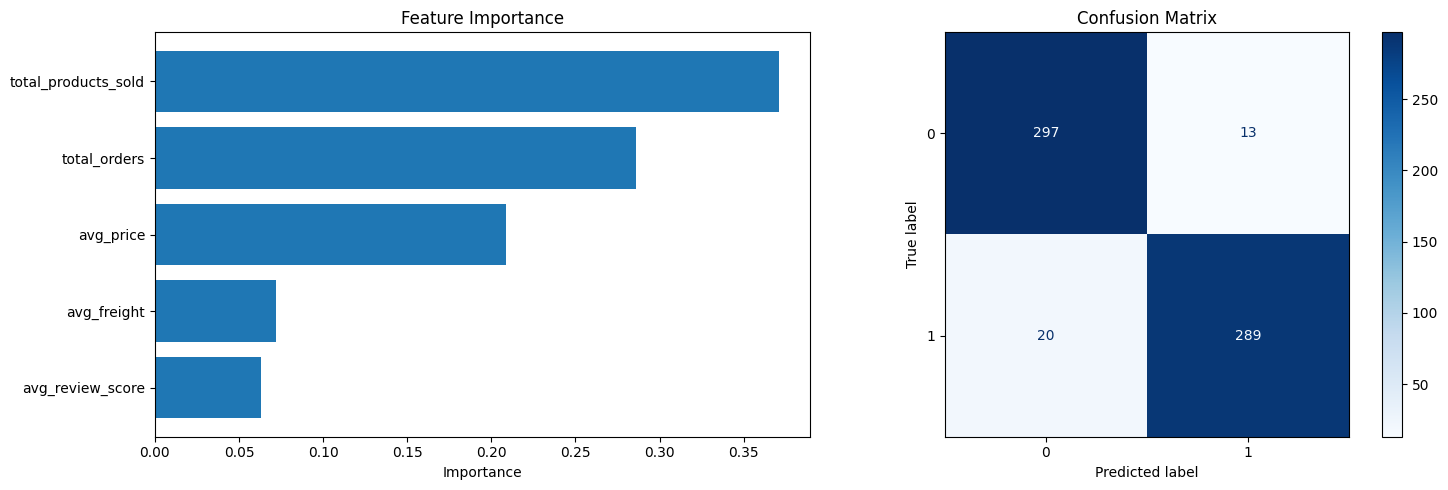

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature importance
rf = model.named_steps['clf']
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=True)

axes[0].barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
axes[0].set_title('Feature Importance')
axes[0].set_xlabel('Importance')

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

## Additional analysis


In [11]:
print("\n Additional Analysis:")
print(f"Total sellers: {len(seller_data)}")
print(f"Profitable sellers: {seller_data['profitable'].sum()} ({seller_data['profitable'].mean()*100:.1f}%)")
print(f"Median revenue: BRL {median_revenue:,.2f}")

# Show top features
print("\n Top Features by Importance:")
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.3f}")



 Additional Analysis:
Total sellers: 3095
Profitable sellers: 1547 (50.0%)
Median revenue: BRL 1,255.71

 Top Features by Importance:
total_orders: 0.286
total_products_sold: 0.371
avg_price: 0.208
avg_freight: 0.072
avg_review_score: 0.063


## Correlation Heatmap — What drives profitability?

## Goal: Identify relationships between key features and total revenue.

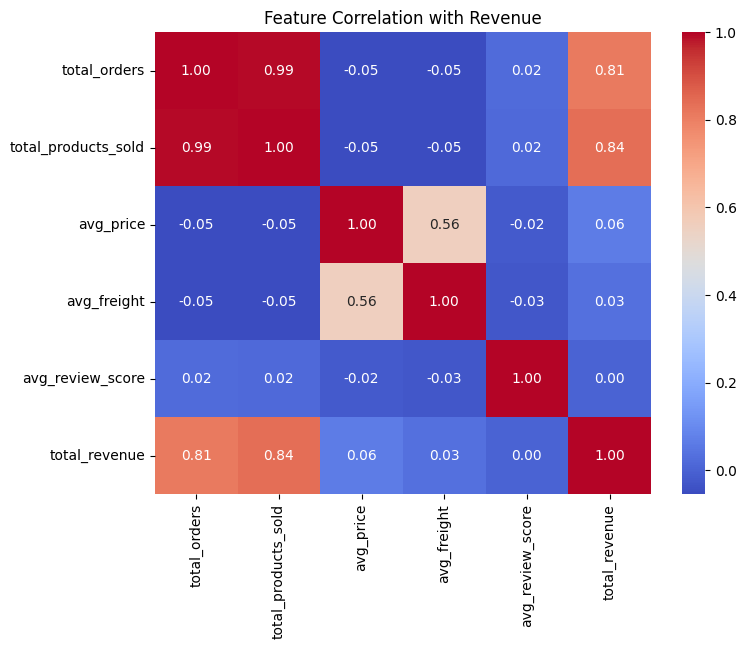

In [12]:
plt.figure(figsize=(8,6))
corr = seller_data[['total_orders', 'total_products_sold', 'avg_price', 'avg_freight', 'avg_review_score', 'total_revenue']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation with Revenue")
plt.show()

## Top States by Profitability

## Goal: Discover which regions have the highest ratio of profitable sellers.



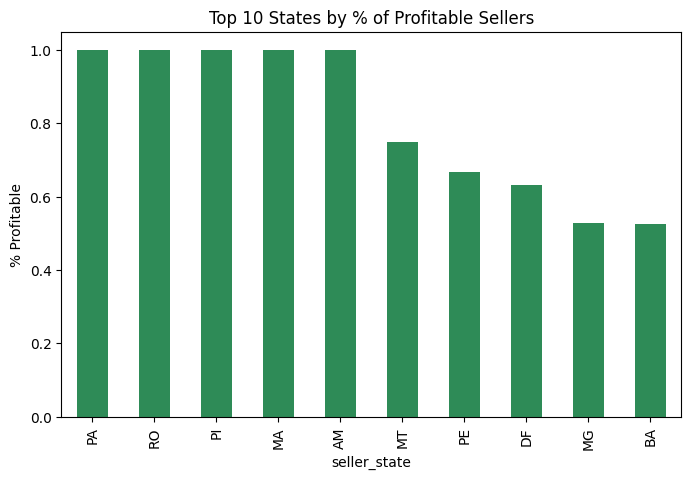

In [13]:
top_states = seller_data.groupby('seller_state')['profitable'].mean().sort_values(ascending=False).head(10)
top_states.plot(kind='bar', color='seagreen', title='Top 10 States by % of Profitable Sellers', figsize=(8,5))
plt.ylabel('% Profitable')
plt.show()

## Review Score vs. Revenue — “Do good ratings pay off?”

## Goal: Measure how customer satisfaction impacts revenue.


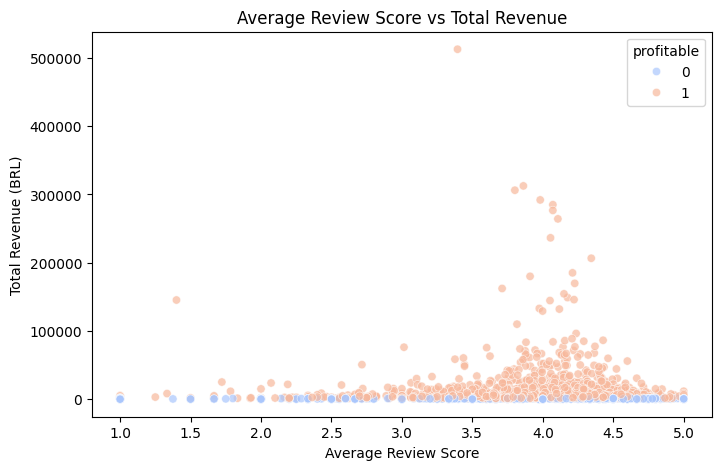

In [14]:

plt.figure(figsize=(8,5))
sns.scatterplot(data=seller_data, x='avg_review_score', y='total_revenue', hue='profitable', palette='coolwarm', alpha=0.7)
plt.title("Average Review Score vs Total Revenue")
plt.xlabel("Average Review Score")
plt.ylabel("Total Revenue (BRL)")
plt.show()

## Top 5 Best Sellers — Who dominates the market?

## Goal: Identify and visualize the top-performing sellers by total revenue.


🏆 Top 5 Best Sellers (by Total Revenue):


,seller_id,seller_city,seller_state,total_revenue,total_orders,avg_review_score
1535,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,512645.19,982,3.394773
192,1025f0e2d44d7041d6cf58b6550e0bfa,sao paulo,SP,312456.49,915,3.862116
881,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,306138.80,1806,3.801692
368,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,291918.98,1404,3.981583
1013,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,284903.08,358,4.071264



These top 5 sellers generate 8.4% of all platform revenue.
Average customer rating among top sellers: 3.82★
Most common seller state among them: SP


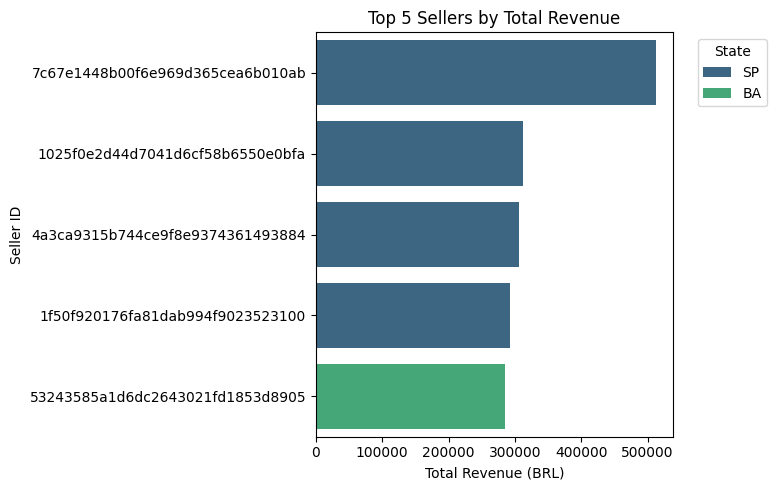

In [15]:

# Sort by revenue and take top 5
top_5_sellers = seller_data.sort_values(by='total_revenue', ascending=False).head(5)

# Display the table
print("🏆 Top 5 Best Sellers (by Total Revenue):")
display(top_5_sellers[['seller_id', 'seller_city', 'seller_state',
                       'total_revenue', 'total_orders', 'avg_review_score']])

# Calculate their share of total revenue
top5_share = 100 * top_5_sellers['total_revenue'].sum() / seller_data['total_revenue'].sum()
avg_rating_top5 = top_5_sellers['avg_review_score'].mean()
top_state = top_5_sellers['seller_state'].mode()[0]

print(f"\nThese top 5 sellers generate {top5_share:.1f}% of all platform revenue.")
print(f"Average customer rating among top sellers: {avg_rating_top5:.2f}★")
print(f"Most common seller state among them: {top_state}")

# Visualization — horizontal bar chart
plt.figure(figsize=(8,5))
sns.barplot(
    data=top_5_sellers,
    y='seller_id',
    x='total_revenue',
    hue='seller_state',
    dodge=False,
    palette='viridis'
)
plt.title('Top 5 Sellers by Total Revenue')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Seller ID')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Geographic Performance (Top States)

## Goal: Discover which states have the highest share of profitable sellers.


## Usefulness: Helps guide logistics and regional marketing strategy

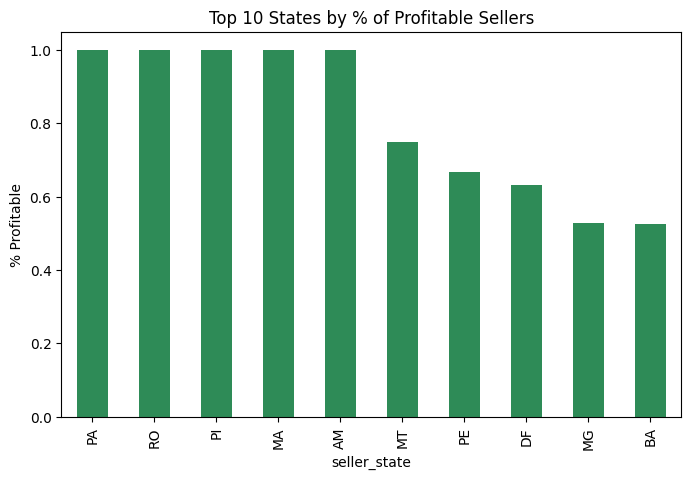

In [16]:
top_states = seller_data.groupby('seller_state')['profitable'].mean().sort_values(ascending=False).head(10)
top_states.plot(kind='bar', color='seagreen', title='Top 10 States by % of Profitable Sellers', figsize=(8,5))
plt.ylabel('% Profitable')
plt.show()

## Top 5 Best Rated Sellers — Who delivers the best experience?

In [17]:

# Sort sellers by average review score
top_5_rated = seller_data.sort_values(by='avg_review_score', ascending=False).head(5)

# Display the table only
print("🌟 Top 5 Best Rated Sellers:")
display(top_5_rated[['seller_id', 'seller_city', 'seller_state',
                     'avg_review_score', 'total_revenue', 'total_orders']])

# Calculate simple insights
avg_revenue_rated = top_5_rated['total_revenue'].mean()
print(f"\nAverage revenue among top-rated sellers: BRL {avg_revenue_rated:,.2f}")


🌟 Top 5 Best Rated Sellers:


,seller_id,seller_city,seller_state,avg_review_score,total_revenue,total_orders
2351,c3251e13f1bbda6c74e37c160f991e19,porto ferreira,SP,5.0,513.08,2
1829,95cca791657aabeff15a07eb152d7841,palotina,PR,5.0,28.22,1
678,398cb257329ef7af7f1943a8974a3cbc,salvador,BA,5.0,161.37,1
679,39a5005f2605cbdb4f9ac14485cabfd1,barretos,SP,5.0,2578.36,3
2532,d149de2f383552baea37a7198c2296ce,sao paulo,SP,5.0,354.37,3



Average revenue among top-rated sellers: BRL 727.08


## Bottom 5 Sellers — Who needs improvement?


In [18]:

# Sort sellers by lowest total revenue
bottom_5 = seller_data.sort_values(by='total_revenue', ascending=True).head(5)

# Display the table only
print("⚠️ Bottom 5 Sellers (Lowest Revenue):")
display(bottom_5[['seller_id', 'seller_city', 'seller_state',
                  'total_revenue', 'avg_review_score', 'total_orders']])

# Summary insight
avg_rating_bottom = bottom_5['avg_review_score'].mean()
print(f"\nAverage review score among bottom sellers: {avg_rating_bottom:.2f}★")


⚠️ Bottom 5 Sellers (Lowest Revenue):


,seller_id,seller_city,seller_state,total_revenue,avg_review_score,total_orders
2519,cf6f6bc4df3999b9c6440f124fb2f687,sao paulo,SP,12.22,5.0,1
1465,77128dec4bec4878c37ab7d6169d6f26,sao paulo,SP,15.22,5.0,1
869,4965a7002cca77301c82d3f91b82e1a9,sorocaba,SP,16.36,5.0,1
1370,702835e4b785b67a084280efca355756,juiz de fora,MG,18.56,5.0,1
2087,ad14615bdd492b01b0d97922e87cb87f,tubarao,SC,19.21,5.0,1



Average review score among bottom sellers: 5.00★


## OLIST FACTS

In [19]:
# ============================
# Olist E-commerce Dataset — Facts & Insights
# ============================

print("📦 Olist E-commerce Dataset — Summary Facts\n")

# Number of records in each table
datasets = {
    "Customers": customers,
    "Geolocation": geolocation,
    "Order Items": order_items,
    "Payments": order_payments,
    "Reviews": order_reviews,
    "Orders": orders,
    "Products": products,
    "Sellers": sellers,
    "Category Translation": category_translation
}

for name, df in datasets.items():
    print(f"{name:<22} → {df.shape[0]:>8,} rows × {df.shape[1]} columns")

# Date range in orders
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
start_date = orders['order_purchase_timestamp'].min().strftime("%Y-%m-%d")
end_date = orders['order_purchase_timestamp'].max().strftime("%Y-%m-%d")

print(f"\n🗓️  Data timeframe: {start_date} → {end_date}")

# Order status distribution
status_counts = orders['order_status'].value_counts(normalize=True) * 100
print("\n📊 Order Status Distribution (%):")
print(status_counts.round(2))

# Average review score
avg_review = order_reviews['review_score'].mean()
print(f"\n⭐ Average Customer Review Score: {avg_review:.2f} / 5")

# Unique sellers and customers
unique_sellers = sellers['seller_id'].nunique()
unique_customers = customers['customer_id'].nunique()
print(f"\n👨‍💼 Unique Sellers: {unique_sellers:,}")
print(f"👩‍💻 Unique Customers: {unique_customers:,}")

# Total revenue
total_revenue = order_payments['payment_value'].sum()
print(f"\n💰 Total Recorded Revenue: BRL {total_revenue:,.2f}")

# Most common payment method
most_common_payment = order_payments['payment_type'].mode()[0]
print(f"💳 Most Common Payment Method: {most_common_payment}")

# Top seller states
top_sellers_state = sellers['seller_state'].value_counts().head(5)
print("\n📍 Top 5 Seller States:")
print(top_sellers_state)

# Top product categories
top_categories = products['product_category_name'].value_counts().head(5)
print("\n🛍️  Top 5 Product Categories:")
print(top_categories)

# Seller revenue statistics
print("\n💼 Seller Revenue Summary (BRL):")
print(seller_data['total_revenue'].describe()[['min','mean','50%','max']])

# Percentage of profitable sellers
profitable_ratio = seller_data['profitable'].mean() * 100
print(f"\n📈 Profitable Sellers: {profitable_ratio:.1f}% of all sellers")

print("\n✅ Dataset facts generated successfully.")


📦 Olist E-commerce Dataset — Summary Facts

Customers              →   99,441 rows × 5 columns
Geolocation            → 1,000,163 rows × 5 columns
Order Items            →  112,650 rows × 7 columns
Payments               →  103,886 rows × 5 columns
Reviews                →   99,224 rows × 7 columns
Orders                 →   99,441 rows × 8 columns
Products               →   32,951 rows × 9 columns
Sellers                →    3,095 rows × 4 columns
Category Translation   →       71 rows × 2 columns

🗓️  Data timeframe: 2016-09-04 → 2018-10-17

📊 Order Status Distribution (%):
order_status
delivered      97.02
shipped         1.11
canceled        0.63
unavailable     0.61
invoiced        0.32
processing      0.30
created         0.01
approved        0.00
Name: proportion, dtype: float64

⭐ Average Customer Review Score: 4.09 / 5

👨‍💼 Unique Sellers: 3,095
👩‍💻 Unique Customers: 99,441

💰 Total Recorded Revenue: BRL 16,008,872.12
💳 Most Common Payment Method: credit_card

📍 Top 5 Seller S

In [22]:
# ============================
# 📊 Olist E-commerce Dataset — Facts & Insights (Display Mode)
# ============================

import pandas as pd
from IPython.display import display, Markdown

display(Markdown("## 📦 Olist E-commerce Dataset — Summary Facts"))

# ---- Table shapes ----
summary_data = []
datasets = {
    "Customers": customers,
    "Geolocation": geolocation,
    "Order Items": order_items,
    "Payments": order_payments,
    "Reviews": order_reviews,
    "Orders": orders,
    "Products": products,
    "Sellers": sellers,
    "Category Translation": category_translation
}

for name, df in datasets.items():
    summary_data.append([name, f"{df.shape[0]:,}", df.shape[1]])

summary_df = pd.DataFrame(summary_data, columns=["Dataset", "Rows", "Columns"])
display(Markdown("### Dataset Sizes"))
display(summary_df)

# ---- Timeframe ----
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
start_date = orders['order_purchase_timestamp'].min().strftime("%Y-%m-%d")
end_date = orders['order_purchase_timestamp'].max().strftime("%Y-%m-%d")

display(Markdown(f"**🗓️ Data timeframe:** {start_date} → {end_date}"))

# ---- Order status ----
status_counts = orders['order_status'].value_counts(normalize=True).mul(100).round(2)
display(Markdown("### Order Status Distribution (%)"))
display(status_counts.to_frame(name="Percentage (%)"))

# ---- Review score ----
avg_review = order_reviews['review_score'].mean()
display(Markdown(f"**⭐ Average Customer Review Score:** {avg_review:.2f} / 5"))

# ---- Unique sellers/customers ----
unique_sellers = sellers['seller_id'].nunique()
unique_customers = customers['customer_id'].nunique()
display(Markdown(f"**👨‍💼 Unique Sellers:** {unique_sellers:,}"))
display(Markdown(f"**👩‍💻 Unique Customers:** {unique_customers:,}"))

# ---- Revenue ----
total_revenue = order_payments['payment_value'].sum()
display(Markdown(f"**💰 Total Recorded Revenue:** BRL {total_revenue:,.2f}"))

# ---- Payment method ----
most_common_payment = order_payments['payment_type'].mode()[0]
display(Markdown(f"**💳 Most Common Payment Method:** {most_common_payment}"))

# ---- Top states ----
top_sellers_state = sellers['seller_state'].value_counts().head(5)
display(Markdown("### 📍 Top 5 Seller States"))
display(top_sellers_state.to_frame(name="Count"))

# ---- Top product categories ----
top_categories = products['product_category_name'].value_counts().head(5)
display(Markdown("### 🛍️ Top 5 Product Categories"))
display(top_categories.to_frame(name="Count"))

# ---- Seller revenue summary ----
display(Markdown("### 💼 Seller Revenue Summary (BRL)"))
display(seller_data['total_revenue'].describe()[['min','mean','50%','max']].to_frame())

# ---- Profitable sellers ----
profitable_ratio = seller_data['profitable'].mean() * 100
display(Markdown(f"**📈 Profitable Sellers:** {profitable_ratio:.1f}% of all sellers"))

display(Markdown("✅ **Dataset facts generated successfully.**"))


## 📦 Olist E-commerce Dataset — Summary Facts

### Dataset Sizes

,Dataset,Rows,Columns
0,Customers,"99,441",5
1,Geolocation,"1,000,163",5
2,Order Items,"112,650",7
3,Payments,"103,886",5
4,Reviews,"99,224",7
5,Orders,"99,441",8
6,Products,"32,951",9
7,Sellers,"3,095",4
8,Category Translation,71,2


**🗓️ Data timeframe:** 2016-09-04 → 2018-10-17

### Order Status Distribution (%)

,Percentage (%)
order_status,
delivered,97.02
shipped,1.11
canceled,0.63
unavailable,0.61
invoiced,0.32
processing,0.30
created,0.01
approved,0.00


**⭐ Average Customer Review Score:** 4.09 / 5

**👨‍💼 Unique Sellers:** 3,095

**👩‍💻 Unique Customers:** 99,441

**💰 Total Recorded Revenue:** BRL 16,008,872.12

**💳 Most Common Payment Method:** credit_card

### 📍 Top 5 Seller States

,Count
seller_state,
SP,1849
PR,349
MG,244
SC,190
RJ,171


### 🛍️ Top 5 Product Categories

,Count
product_category_name,
cama_mesa_banho,3029
esporte_lazer,2867
moveis_decoracao,2657
beleza_saude,2444
utilidades_domesticas,2335


### 💼 Seller Revenue Summary (BRL)

,total_revenue
min,12.220000
mean,6596.718107
50%,1255.710000
max,512645.190000


**📈 Profitable Sellers:** 50.0% of all sellers

✅ **Dataset facts generated successfully.**

In [23]:
median_revenue = seller_data['total_revenue'].median()
print(f"💰 Median total revenue: BRL {median_revenue:,.2f}")


💰 Median total revenue: BRL 1,255.71


In [21]:
!pip install pyngrok streamlit

from pyngrok import ngrok
import subprocess
import time
import os
import requests

def cleanup():
    try:
        ngrok.kill()
        os.system("pkill -f streamlit")
        os.system("pkill -f ngrok")
        os.system("fuser -k 8501/tcp 8502/tcp 8503/tcp 2>/dev/null")
        time.sleep(3)
    except Exception as e:
        print(f"Cleanup: {e}")

cleanup()

NGROK_AUTH_TOKEN = "34ddysFwXISWWW6um42MVQKsnpD_4DGgG45UWFvCipQPRi5Jm"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
print("Ngrok authentication set successfully")

# Streamlit
def start_streamlit_app(port=8501):
    try:

        os.system(f"fuser -k {port}/tcp 2>/dev/null")
        time.sleep(2)

        process = subprocess.Popen([
            "streamlit", "run", "app.py",
            "--server.port", str(port),
            "--server.headless", "true",
            "--server.address", "0.0.0.0"
        ])

        print(f"Starting Streamlit on port {port}...")
        time.sleep(10)

        try:
            response = requests.get(f"http://localhost:{port}", timeout=10)
            if response.status_code == 200:
                print(f"Streamlit is running on port {port}")
                return process, port
        except:
            print(f"Streamlit failed to start on port {port}")
            process.terminate()
            return None, port

    except Exception as e:
        print(f" Error starting Streamlit: {e}")
        return None, port

ports_to_try = [8501, 8502, 8503, 8504]
streamlit_process = None
success_port = None

for port in ports_to_try:
    streamlit_process, success_port = start_streamlit_app(port)
    if streamlit_process:
        break

if not streamlit_process:
    print("Failed to start Streamlit on any port")
else:
    print(f"Streamlit running successfully on port {success_port}")

    # Ngrok pipeline
    try:
        print("🔗 Creating ngrok tunnel...")
        public_url = ngrok.connect(success_port, bind_tls=True)

        print("\n" + "="*50)
        print(" SUCCESS! Your App is Live! ")
        print("="*50)
        print(f"Public URL: {public_url}")
        print("Share this link with anyone!")
        print("The app will auto-close when this session ends")
        print("="*50)

        tunnels = ngrok.get_tunnels()
        print(f" Active tunnels: {len(tunnels)}")
        for tunnel in tunnels:
            print(f"   - {tunnel.public_url} -> {tunnel.config['addr']}")

    except Exception as e:
        print(f"Failed to create ngrok tunnel: {e}")
        print("\n Alternative solutions:")
        print("1. Wait 2 minutes and try again")
        print("2. Visit https://dashboard.ngrok.com/endpoints/status")
        print("3. Use this command: !ngrok http 8501")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
  7069Ngrok authentication set successfully
Starting Streamlit on port 8501...

  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

Streamlit is running on port 8501
Streamlit running successfully on port 8501
🔗 Creating ngrok tunnel...

 SUCCESS! Your App is Live! 
Public URL: NgrokTunnel: "https://rosalyn-doughiest-ripply.ngrok-free.dev" -> "http://localhost:8501"
Share this link with anyone!
The app will auto-close when this session ends
 Active tunnels: 1
   - https://rosalyn-doughiest-ripply.ngrok-free.dev -> http://localhost:8501
